# Pipline
##### -load data
##### -EDA
##### - Data Visualization
##### -heal data and remove outliers
##### -work with shops/items/cats objects and features
##### -create matrix as product of item/shop pairs within each month in the train set
##### -get monthly sales for each item/shop pair in the train set and merge it to the matrix
##### -clip item_cnt_month by (0,20)
##### -append test to the matrix, fill 34 month nans with zeros
##### -merge shops/items/cats to the matrix
##### -add target lag features
##### -add mean encoded features
##### -add price trend features
##### -add month
##### -add days
##### -add months since last sale/months since first sale features
##### -cut first year and drop columns which can not be calculated for the test set
##### -select best features
##### -set validation strategy 34 test, 33 validation, less than 33 train
##### -fit the model, predict and clip targets for the test set

# Part 1, perfect features

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=11, micro=9, releaselevel='final', serial=0)

In [2]:
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')
train = pd.read_csv('sales_train.csv')
sample = pd.read_csv('sample_submission.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('test.csv').set_index('ID')

In [3]:
print(f'sales_train verilerindeki satır sayısı: {train.shape[0]}')
print(f'sales_train verilerindeki sütun sayısı: {train.shape[1]}')
print(f'sales_train verilerindeki değer sayısı: {train.count().sum()}')
print(f'sales_train verilerindeki eksik değerlerin sayısı: {sum(train.isna().sum())}')
train.head()

sales_train verilerindeki satır sayısı: 2935849
sales_train verilerindeki sütun sayısı: 6
sales_train verilerindeki değer sayısı: 17615094
sales_train verilerindeki eksik değerlerin sayısı: 0


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
print(f'test verilerindeki satır sayısı: {test.shape[0]}')
print(f'test verilerindeki sütun sayısı: {test.shape[1]}')
print(f'test verilerindeki değer sayısı: {test.count().sum()}')
print(f'test verilerindeki eksik değerlerin sayısı: {sum(test.isna().sum())}')
cats.head()

test verilerindeki satır sayısı: 214200
test verilerindeki sütun sayısı: 2
test verilerindeki değer sayısı: 428400
test verilerindeki eksik değerlerin sayısı: 0


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [5]:
print(f'items verilerindeki satır sayısı: {items.shape[0]}')
print(f'items verilerindeki sütun sayısı: {items.shape[1]}')
print(f'items verilerindeki değer sayısı: {items.count().sum()}')
print(f'items verilerindeki eksik değerlerin sayısı: {sum(items.isna().sum())}')
items.head()

items verilerindeki satır sayısı: 22170
items verilerindeki sütun sayısı: 3
items verilerindeki değer sayısı: 66510
items verilerindeki eksik değerlerin sayısı: 0


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
print(f'sample_submission verilerindeki satır sayısı: {sample.shape[0]}')
print(f'sample_submission verilerindeki sütun sayısı: {sample.shape[1]}')
print(f'sample_submission verilerindeki değer sayısı: {sample.count().sum()}')
print(f'sample_submission verilerindeki eksik değerlerin sayısı: {sum(sample.isna().sum())}')
sample.head()

sample_submission verilerindeki satır sayısı: 214200
sample_submission verilerindeki sütun sayısı: 2
sample_submission verilerindeki değer sayısı: 428400
sample_submission verilerindeki eksik değerlerin sayısı: 0


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [7]:
print(f'shops verilerindeki satır sayısı: {shops.shape[0]}')
print(f'shops verilerindeki sütun sayısı: {shops.shape[1]}')
print(f'shops verilerindeki değer sayısı: {shops.count().sum()}')
print(f'shops verilerindeki eksik değerlerin sayısı: {sum(shops.isna().sum())}')
shops.head()

shops verilerindeki satır sayısı: 60
shops verilerindeki sütun sayısı: 2
shops verilerindeki değer sayısı: 120
shops verilerindeki eksik değerlerin sayısı: 0


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [8]:
print(f'item_categories verilerindeki satır sayısı: {cats.shape[0]}')
print(f'item_categories verilerindeki sütun sayısı: {cats.shape[1]}')
print(f'item_categories verilerindeki değer sayısı: {cats.count().sum()}')
print(f'item_categories verilerindeki eksik değerlerin sayısı: {sum(cats.isna().sum())}')
cats.head()

item_categories verilerindeki satır sayısı: 84
item_categories verilerindeki sütun sayısı: 2
item_categories verilerindeki değer sayısı: 168
item_categories verilerindeki eksik değerlerin sayısı: 0


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


#### Bring all the data together to create a clear EDA and find some compelling insights from the data.

In [9]:
df_eda = pd.merge(train, shops, how='left', left_on = 'shop_id', right_on = 'shop_id')
df_eda = pd.merge(df_eda, items, how='left', left_on='item_id', right_on='item_id')
df_eda = pd.merge(df_eda, cats, how='left', left_on='item_category_id', right_on='item_category_id')
df_eda.drop(['item_id', 'item_category_id', 'shop_id'], axis=1, inplace=True)
df_eda.head()

,date,date_block_num,item_price,item_cnt_day,shop_name,item_name,item_category_name
0,02.01.2013,0,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray
1,03.01.2013,0,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,Музыка - Винил
2,05.01.2013,0,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,Музыка - Винил
3,06.01.2013,0,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,Музыка - Винил
4,15.01.2013,0,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),Музыка - CD фирменного производства


In [10]:
print(df_eda.shape)

(2935849, 7)


In [11]:
df_eda.columns

Index(['date', 'date_block_num', 'item_price', 'item_cnt_day', 'shop_name',
       'item_name', 'item_category_name'],
      dtype='object')

In [12]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 7 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      int64  
 2   item_price          float64
 3   item_cnt_day        float64
 4   shop_name           object 
 5   item_name           object 
 6   item_category_name  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 156.8+ MB


#### Check if we have duplicate rows.

In [13]:
df_eda.duplicated().sum()

6

In [14]:
# Yinelenen satırlara bir göz atın (ilk satırlar)
df_eda[df_eda.duplicated(keep='first')]

,date,date_block_num,item_price,item_cnt_day,shop_name,item_name,item_category_name
76962,05.01.2013,0,149.0,1.0,"Химки ТЦ ""Мега""",УЧЕНИК ЧАРОДЕЯ (регион),Кино - DVD
1435367,23.02.2014,13,999.0,1.0,"Тюмень ТЦ ""Гудвин""","Far Cry 3 (Classics) [Xbox 360, русская версия]",Игры - XBOX 360
1496766,23.03.2014,14,999.0,1.0,"Москва МТРЦ ""Афи Молл""","Far Cry 3 (Classics) [Xbox 360, русская версия]",Игры - XBOX 360
1671873,01.05.2014,16,999.0,1.0,"Тюмень ТЦ ""Гудвин""","Far Cry 3 (Classics) [Xbox 360, русская версия]",Игры - XBOX 360
1866340,12.07.2014,18,999.0,1.0,"Москва ТРК ""Атриум""","Far Cry 3 (Classics) [Xbox 360, русская версия]",Игры - XBOX 360
2198566,31.12.2014,23,499.0,1.0,"СПб ТК ""Невский Центр""",ЧЕЛОВЕК ДОЖДЯ (BD),Кино - Blu-Ray


#### Take a look at the duplicate lines (second lines)

In [15]:
df_eda[df_eda.duplicated(keep='last')]

,date,date_block_num,item_price,item_cnt_day,shop_name,item_name,item_category_name
76961,05.01.2013,0,149.0,1.0,"Химки ТЦ ""Мега""",УЧЕНИК ЧАРОДЕЯ (регион),Кино - DVD
1435365,23.02.2014,13,999.0,1.0,"Тюмень ТЦ ""Гудвин""","Far Cry 3 (Classics) [Xbox 360, русская версия]",Игры - XBOX 360
1496765,23.03.2014,14,999.0,1.0,"Москва МТРЦ ""Афи Молл""","Far Cry 3 (Classics) [Xbox 360, русская версия]",Игры - XBOX 360
1671872,01.05.2014,16,999.0,1.0,"Тюмень ТЦ ""Гудвин""","Far Cry 3 (Classics) [Xbox 360, русская версия]",Игры - XBOX 360
1866322,12.07.2014,18,999.0,1.0,"Москва ТРК ""Атриум""","Far Cry 3 (Classics) [Xbox 360, русская версия]",Игры - XBOX 360
2198564,31.12.2014,23,499.0,1.0,"СПб ТК ""Невский Центр""",ЧЕЛОВЕК ДОЖДЯ (BD),Кино - Blu-Ray


In [16]:
# Yinelenen satırları silme
df_eda.drop_duplicates(keep='first', inplace=True)
df_eda.duplicated().sum()

0

## Data Visualization

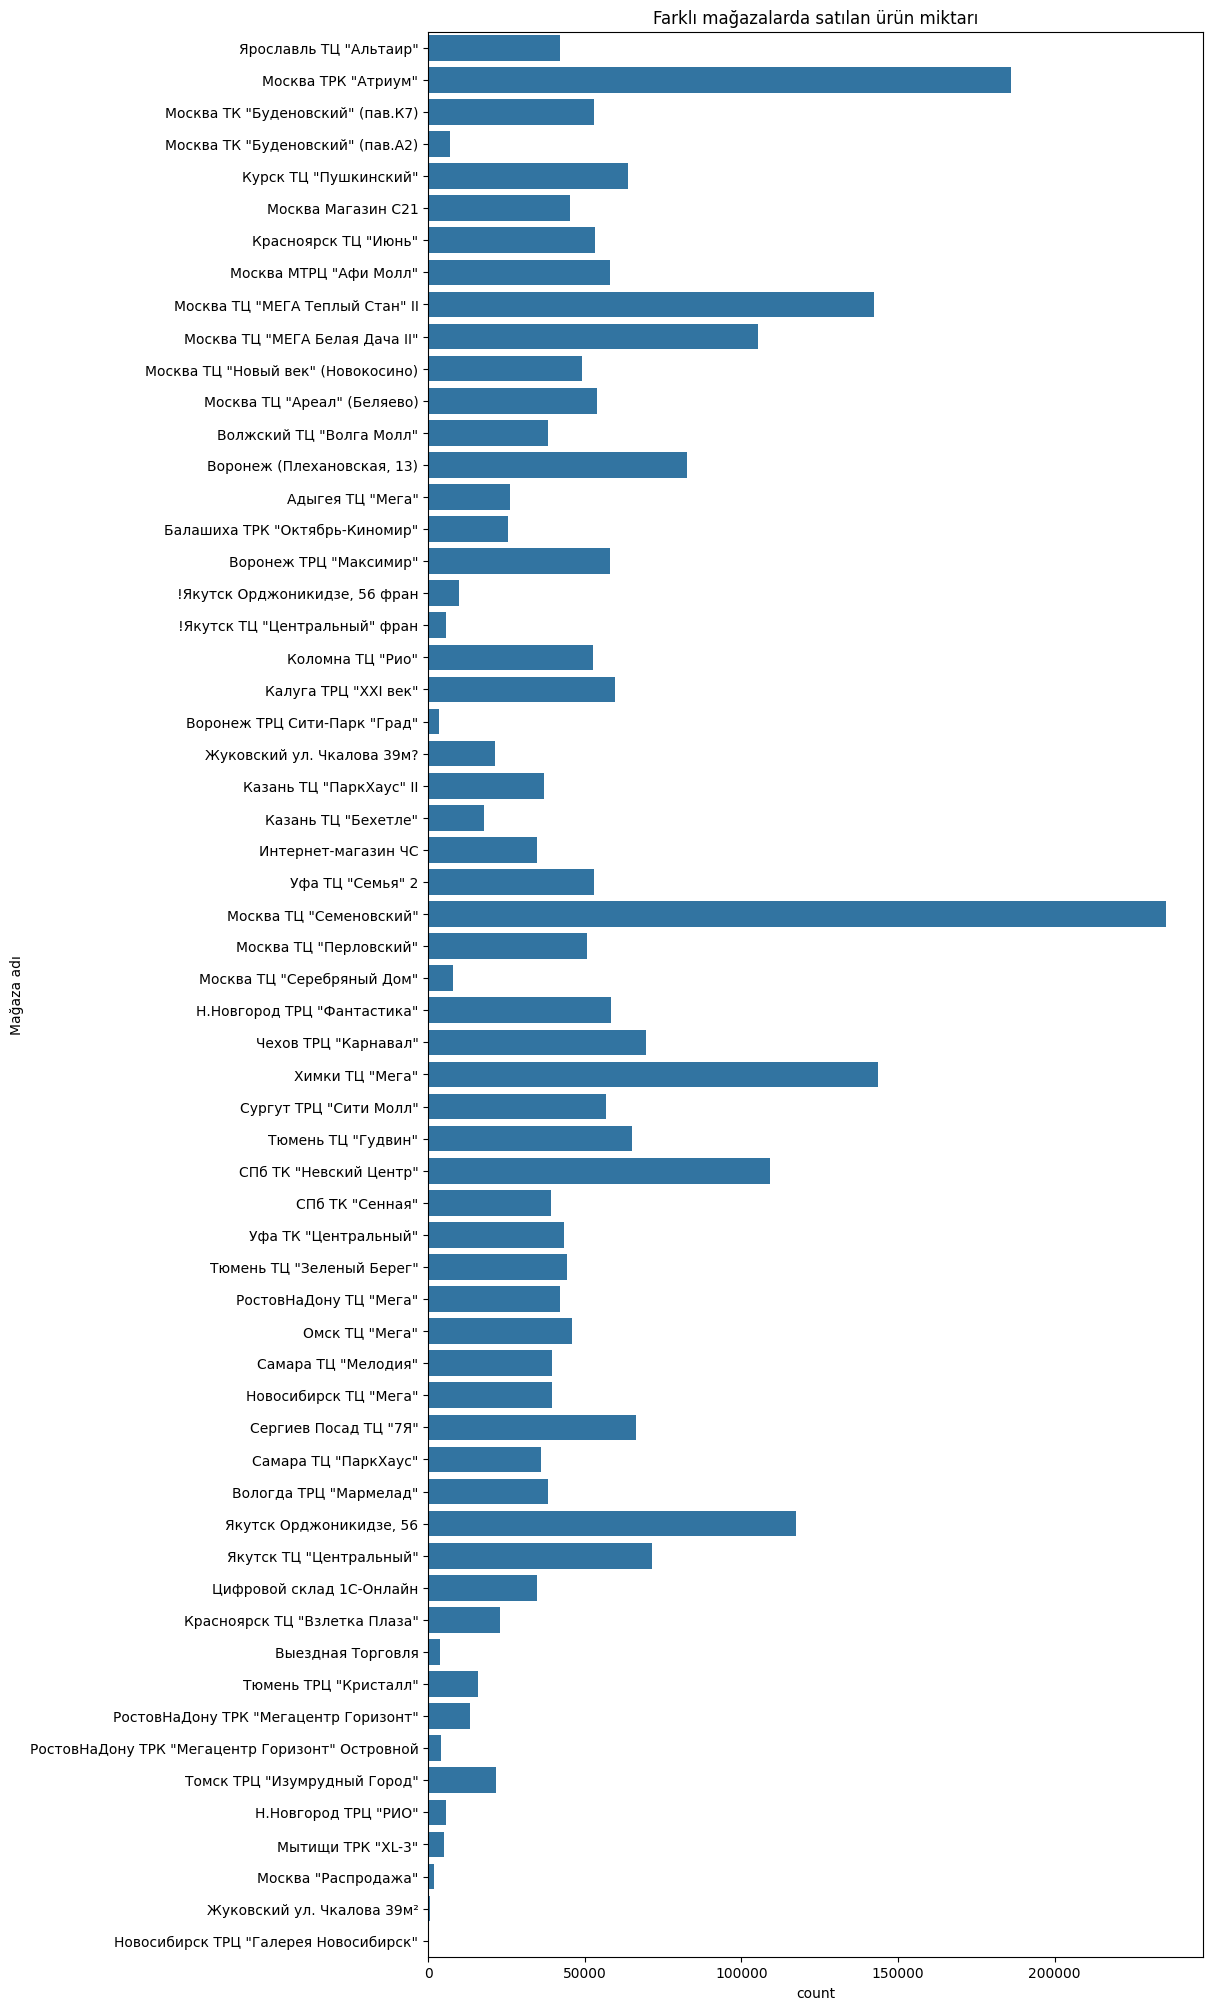

In [17]:
plt.figure(figsize=(10, 25))
sns.countplot(y=df_eda['shop_name'])
plt.ylabel('Mağaza adı')
plt.title('Farklı mağazalarda satılan ürün miktarı')
plt.show()

### Find and plan your top 10 products

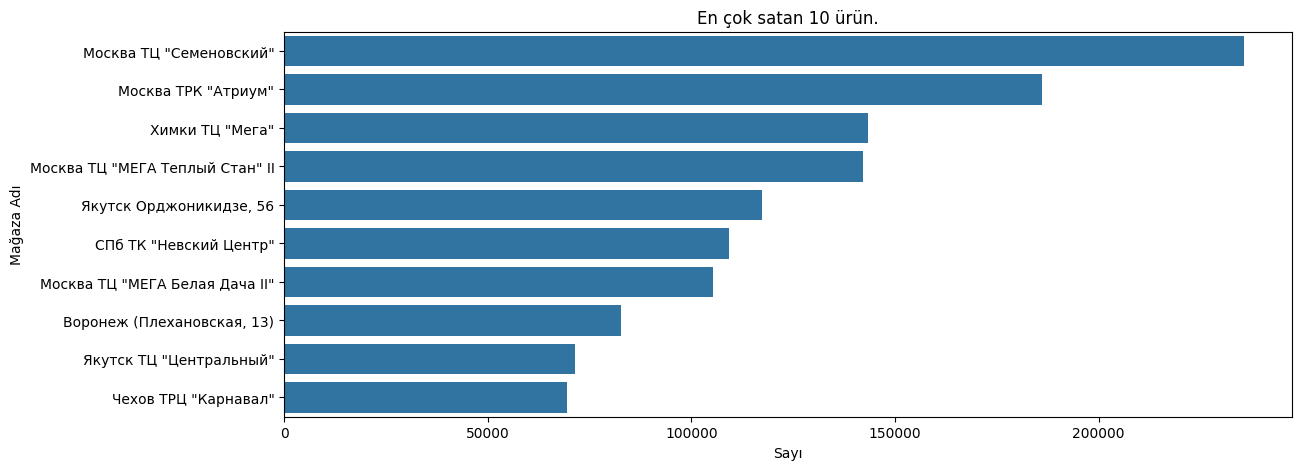

In [18]:
top_10_selling_item = df_eda['shop_name'].value_counts().head(10)
top_10_selling_item = top_10_selling_item.to_frame().reset_index()
top_10_selling_item.columns = ['shop_name', 'count']
plt.figure(figsize=(13, 5))
sns.barplot(data=top_10_selling_item, x='count', y='shop_name')
plt.title('En çok satan 10 ürün.')
plt.ylabel('Mağaza Adı')
plt.xlabel('Sayı')
plt.show()

### Find and plot top 10 selling categories of products

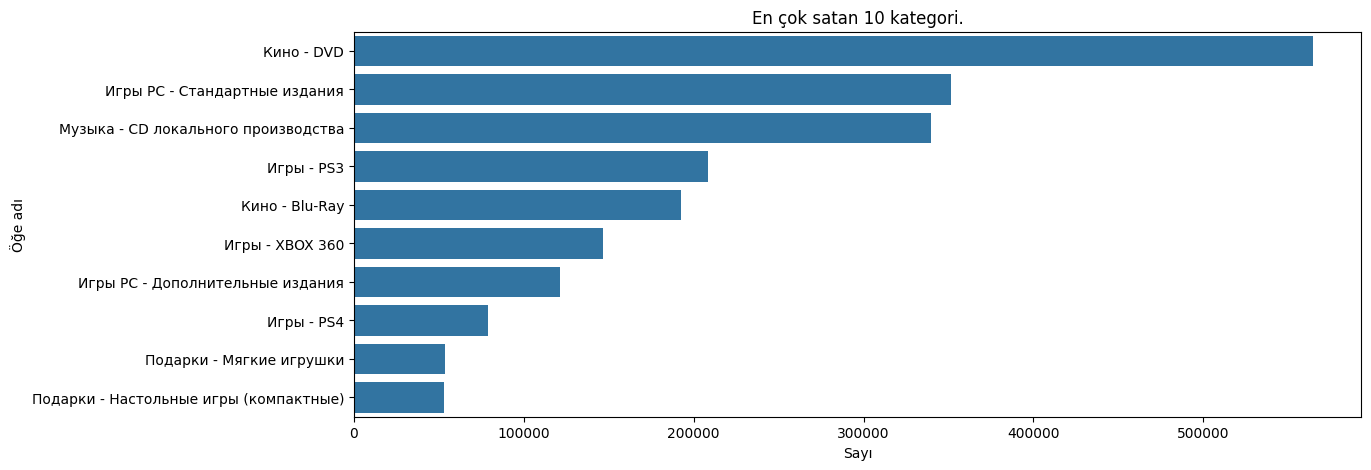

In [19]:
top_10_selling_category = df_eda['item_category_name'].value_counts().head(10)
top_10_selling_category = top_10_selling_category.to_frame().reset_index()
top_10_selling_category.columns = ['item_name', 'count']
plt.figure(figsize=(13, 5))
sns.barplot(data=top_10_selling_category, x='count', y='item_name')
plt.title('En çok satan 10 kategori.')
plt.ylabel('Öğe adı')
plt.xlabel('Sayı')
plt.show()

### Function to plot trends from column list.

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_trend(columns):
    for column in columns:
        movies = df_eda[df_eda['item_category_name'] == column]
        movies = movies.groupby('date_block_num')['item_cnt_day'].sum().to_frame().reset_index()
        plt.figure(figsize=(20,4))
        plt.axhline(y=movies['item_cnt_day'].mean(), color='red', linewidth=1, linestyle='dashed', label='Tüm zamanlar için ortalama satışlar.')
        sns.lineplot(data=movies, x='date_block_num', y='item_cnt_day', label='Trend line.')
        plt.title('Satın alma eğilimi ' + str(column) + '.', fontsize=14)
        plt.legend(loc='upper right')
        plt.xlabel('Ay Sayısı (Ocak 2013ten Ekim 2015e kadar)')
        plt.ylabel('Satılan ürünler')
        plt.show()
        print('\n')

### Calling the function from the previous cell

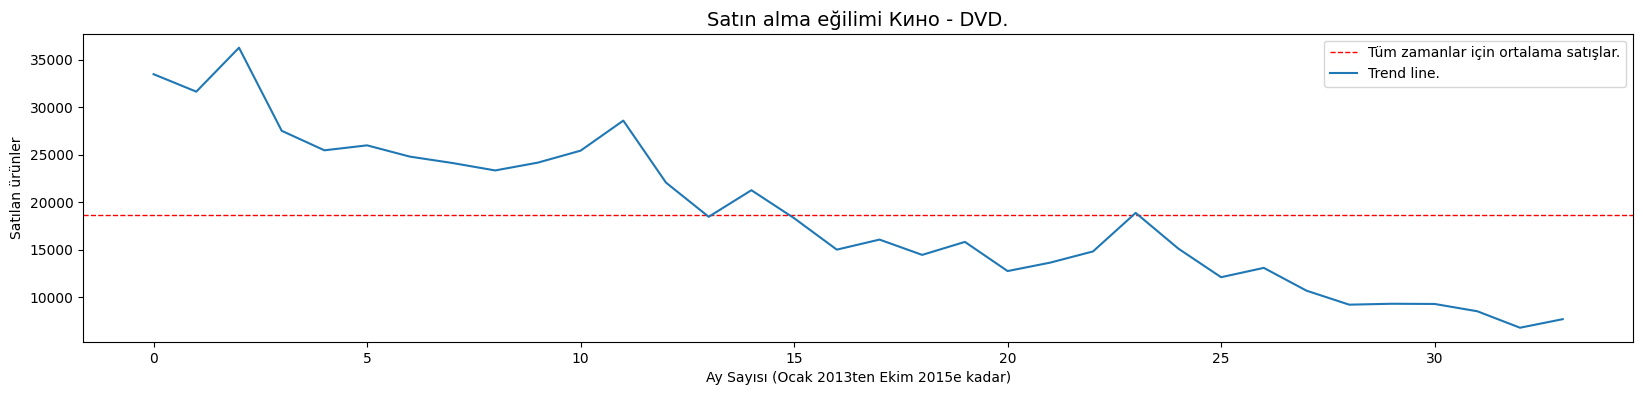

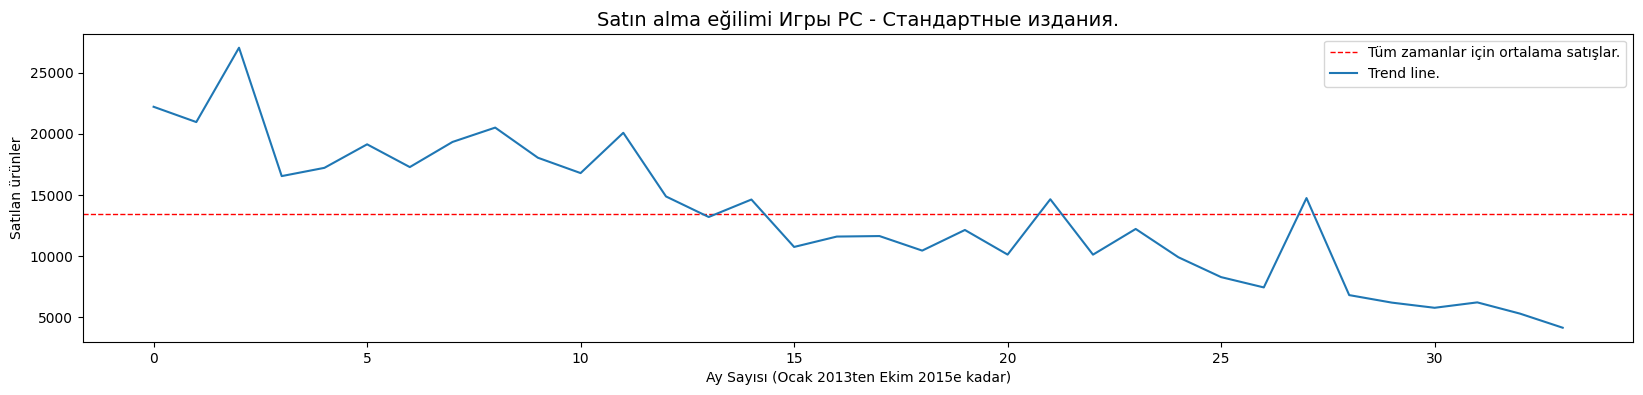

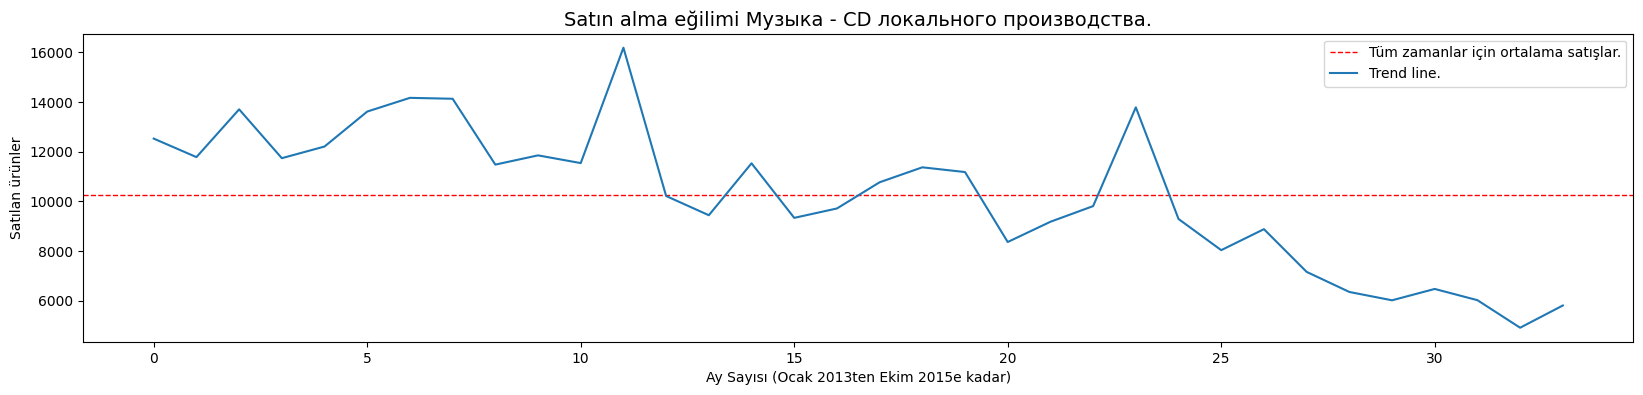

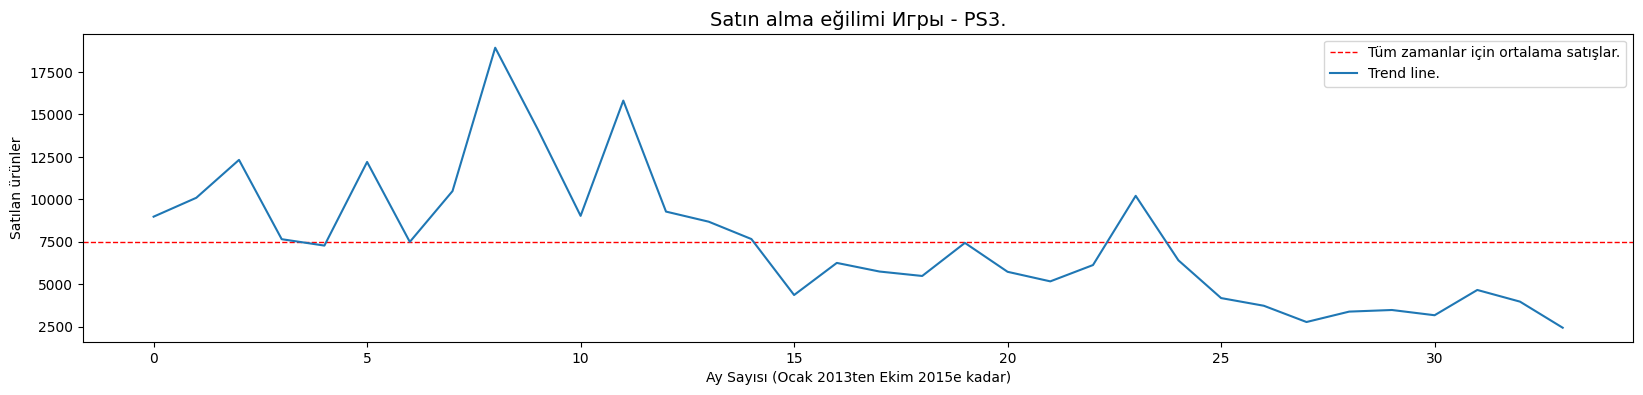

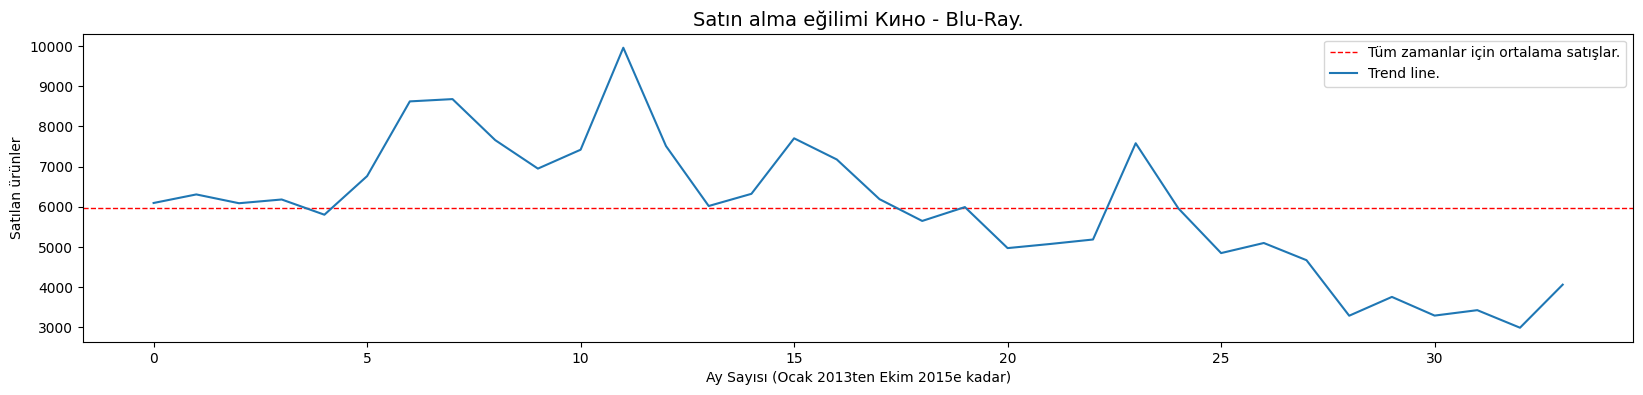

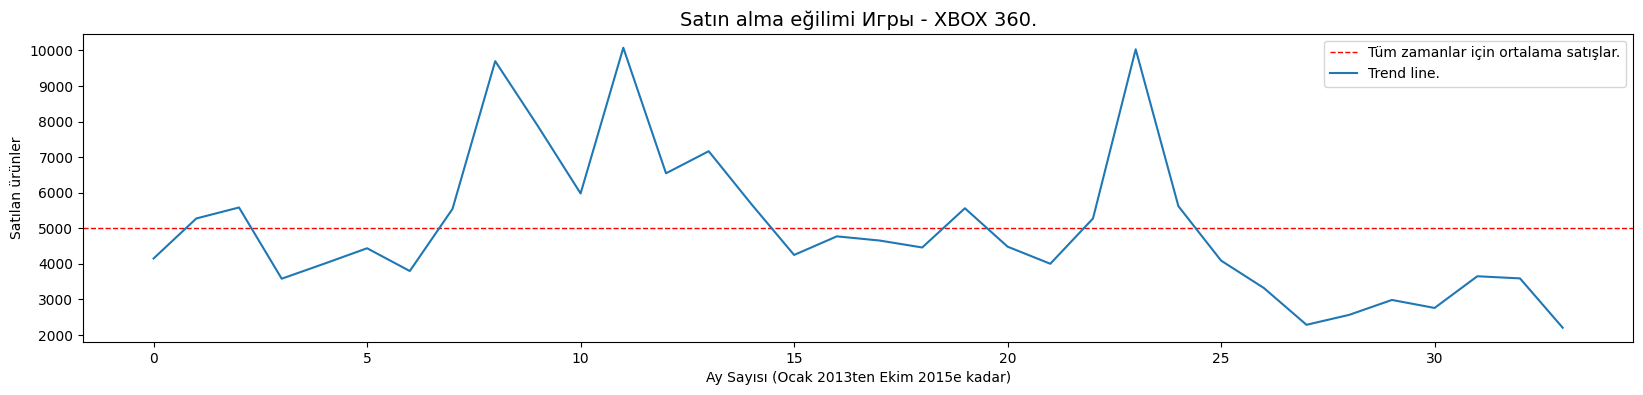

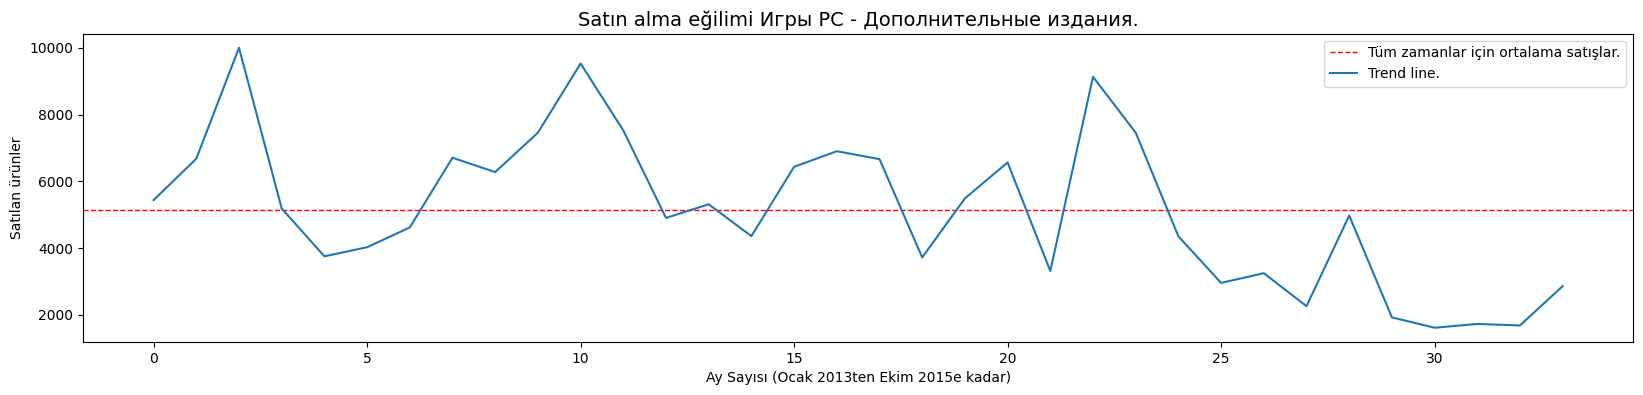

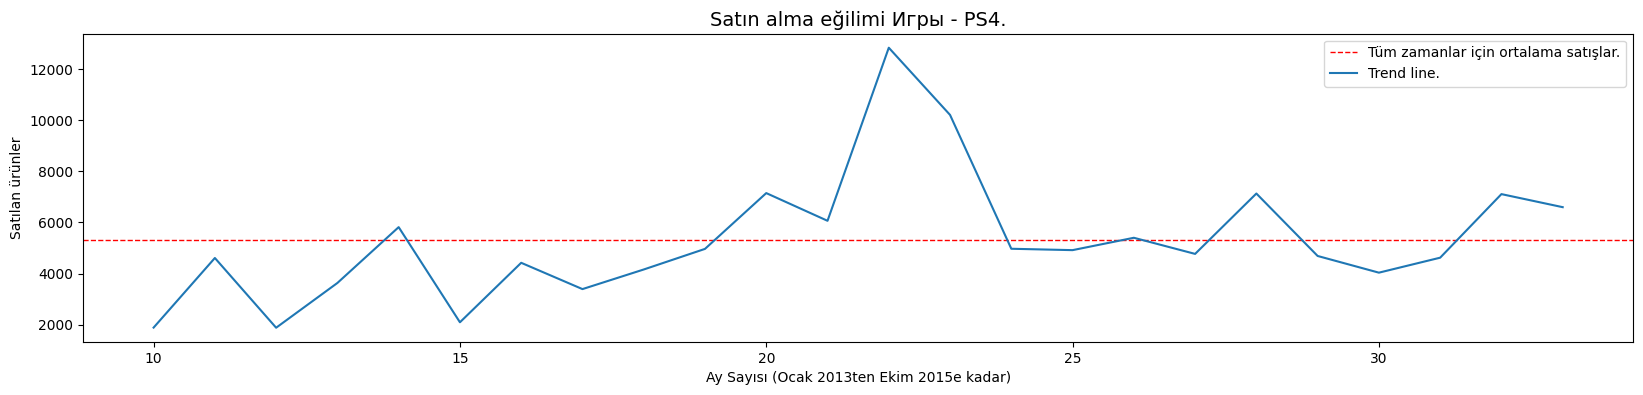

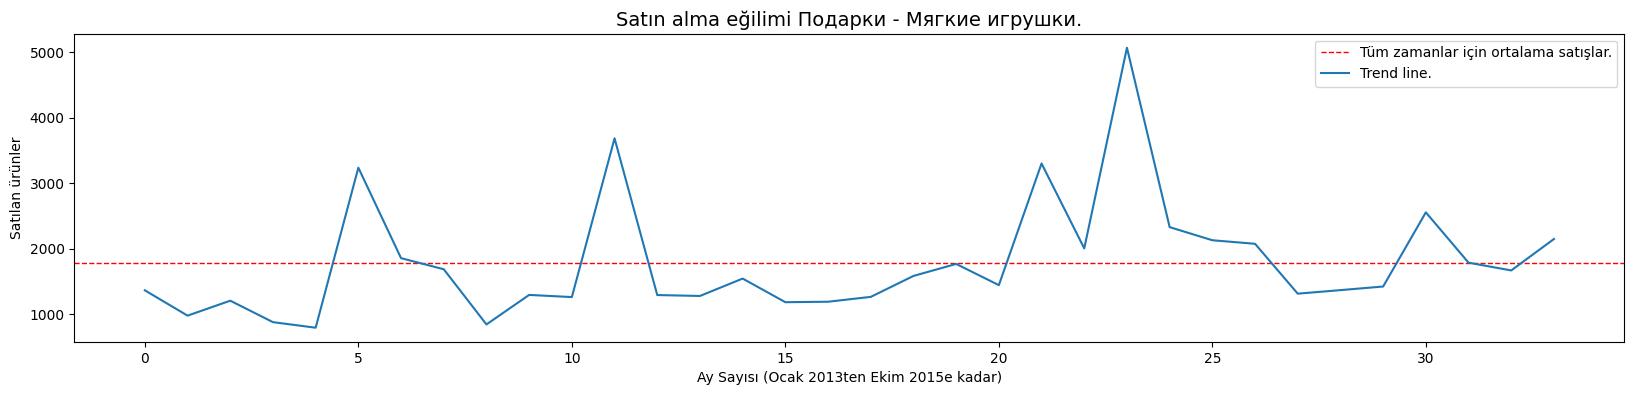

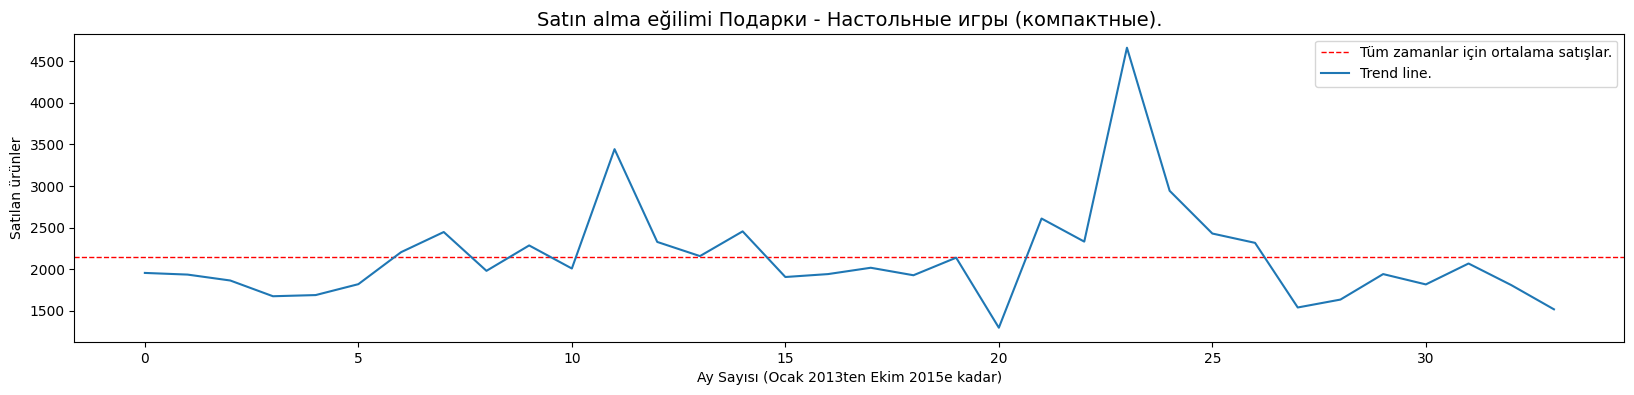

In [21]:
plot_trend(list(top_10_selling_category['item_name']))

#### Here we can clearly see the trend increasing in the category "gifts", "board games" and "games for ps4", while in other categories the trend seems to decrease

#### looking at the number of different categories

In [22]:
'''
plt.rcParams['figure.figsize'] = (22, 12)

sns.barplot(items['item_category_id'], palette='colorblind')
plt.title('Farklı Ürün Kategorileri için Sayım', fontsize=30)
plt.xlabel('Ürün Kategorileri', fontsize=15)
plt.ylabel('Her Kategorideki Öğeler', fontsize=15)
plt.show()
'''

"\nplt.rcParams['figure.figsize'] = (22, 12)\n\nsns.barplot(items['item_category_id'], palette='colorblind')\nplt.title('Farklı Ürün Kategorileri için Sayım', fontsize=30)\nplt.xlabel('Ürün Kategorileri', fontsize=15)\nplt.ylabel('Her Kategorideki Öğeler', fontsize=15)\nplt.show()\n"

#### take a look at the daily distribution of products sold

In [23]:
'''
plt.rcParams['figure.figsize'] = (20, 10)

sns.countplot(train['date_block_num'])
plt.title('Aylara göre tarih blokları', fontsize=30)
plt.xlabel('Farklı ay blokları', fontsize=15)
plt.ylabel('Numara. Satın Alma Sayısı', fontsize=15)
plt.show()
'''

"\nplt.rcParams['figure.figsize'] = (20, 10)\n\nsns.countplot(train['date_block_num'])\nplt.title('Aylara göre tarih blokları', fontsize=30)\nplt.xlabel('Farklı ay blokları', fontsize=15)\nplt.ylabel('Numara. Satın Alma Sayısı', fontsize=15)\nplt.show()\n"

## Outliers


#### There are items with strange prices and sales. After detailed exploration I decided to remove items with price > 100000 and sales > 1001 (1000 is ok).

<Axes: xlabel='item_price'>

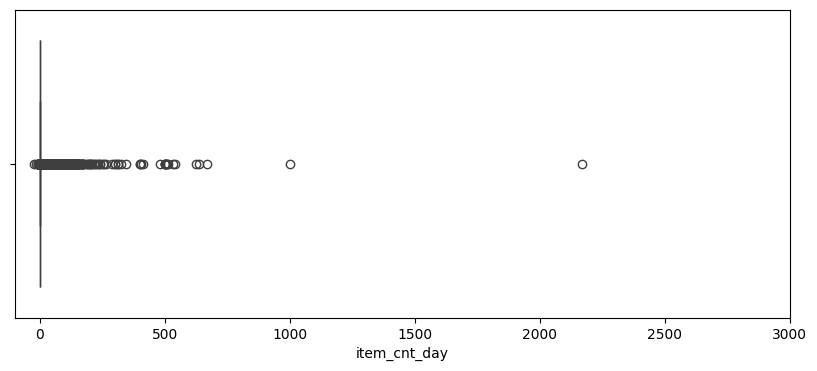

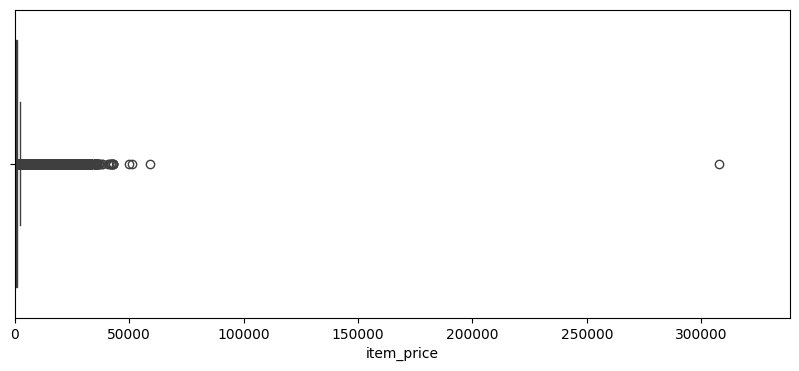

In [24]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [25]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

#### There is one item with price below zero. Fill it with median.

In [26]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

#### Several shops are duplicates of each other (according to its name). Fix train and test set.

In [27]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11


## Shops/Cats/Items preprocessing
### Observations:

#### Each shop_name starts with the city name.
#### Each category contains type and subtype in its name.

In [28]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

## Monthly sales

#### Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and extend it with zero sales for each unique pair within the month. This way train data will be similar to test data.

In [29]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [30]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

6.445208549499512

#### Aggregate train set by shop/item pairs to calculate target aggreagates, then clip(0,20) target value. This way train target will be similar to the test predictions.

#### I use floats instead of ints for item_cnt_month to avoid downcasting it after concatination with the test set later. If it would be int16, after concatination with NaN values it becomes int64, but foat16 becomes float16 even with NaNs.

In [31]:
 train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [32]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts

5.513671875

## Test set

#### To use time tricks append test pairs to the matrix.

In [33]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [34]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.10418248176574707

## Shops/Items/Cats features

In [35]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

3.1525728702545166

## Target lags

In [36]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df 

In [37]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

28.48141098022461

## Mean encoded features

In [38]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

6.676050424575806

In [39]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

33.65110683441162

In [40]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

37.63041138648987

In [41]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

9.367832660675049

In [42]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

9.84860348701477

In [43]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

13.037932634353638

In [44]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

9.814730644226074

In [45]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

9.32485318183899

In [46]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

16.19659996032715

In [47]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

10.460009336471558

In [48]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

10.499555349349976

## Trend features
#### Price trend for the last six months.

In [49]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

135.64890241622925

#### Last month shop revenue trend

In [50]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

15.605820655822754

## Special features

In [51]:
matrix['month'] = matrix['date_block_num'] % 12

#### Number of days in a month. There are no leap years.

In [52]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

#### Months since the last sale for each shop/item pair and for item only. I use programing approach.

#### Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.

In [53]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

707.7871947288513

In [54]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

437.27515721321106

#### Months since the first sale for each shop/item pair and for item only.

In [55]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

2.453526496887207

## Final preparations

#### Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [56]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

4.105276107788086

#### Producing lags brings a lot of nulls.

In [57]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

2.040149211883545

In [58]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta

In [59]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6639294 entries, 4488710 to 11128003
Data columns (total 40 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   city_code                             int8   
 5   item_category_id                      int8   
 6   type_code                             int8   
 7   subtype_code                          int8   
 8   item_cnt_month_lag_1                  float16
 9   item_cnt_month_lag_2                  float16
 10  item_cnt_month_lag_3                  float16
 11  item_cnt_month_lag_6                  float16
 12  item_cnt_month_lag_12                 float16
 13  date_avg_item_cnt_lag_1               float16
 14  date_item_avg_item_cnt_lag_1          float16
 15  date_item_avg

In [60]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

# Part 2, xgboost

In [61]:
data = pd.read_pickle('data.pkl')

#### Select perfect features

In [62]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

#### Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [63]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [64]:
del data
gc.collect();

In [65]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[0]	validation_0-rmse:1.04089	validation_1-rmse:1.02620
[1]	validation_0-rmse:0.95559	validation_1-rmse:0.96856
[2]	validation_0-rmse:0.90911	validation_1-rmse:0.94473
[3]	validation_0-rmse:0.88135	validation_1-rmse:0.92863
[4]	validation_0-rmse:0.86389	validation_1-rmse:0.91938
[5]	validation_0-rmse:0.85297	validation_1-rmse:0.91652
[6]	validation_0-rmse:0.84455	validation_1-rmse:0.91318
[7]	validation_0-rmse:0.83777	validation_1-rmse:0.91145
[8]	validation_0-rmse:0.83342	validation_1-rmse:0.91223
[9]	validation_0-rmse:0.82916	validation_1-rmse:0.91223
[10]	validation_0-rmse:0.82675	validation_1-rmse:0.91240
[11]	validation_0-rmse:0.82432	validation_1-rmse:0.91251
[12]	validation_0-rmse:0.82252	validation_1-rmse:0.91372
[13]	validation_0-rmse:0.82083	validation_1-rmse:0.91446
[14]	validation_0-rmse:0.81920	validation_1-rmse:0.91356
[15]	validation_0-rmse:0.81800	validation_1-rmse:0.91322
[16]	validation_0-rmse:0.81696	validation_1-rmse:0.91245
[17]	validation_0-rmse:0.81588	validation

23.071667194366455

In [66]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

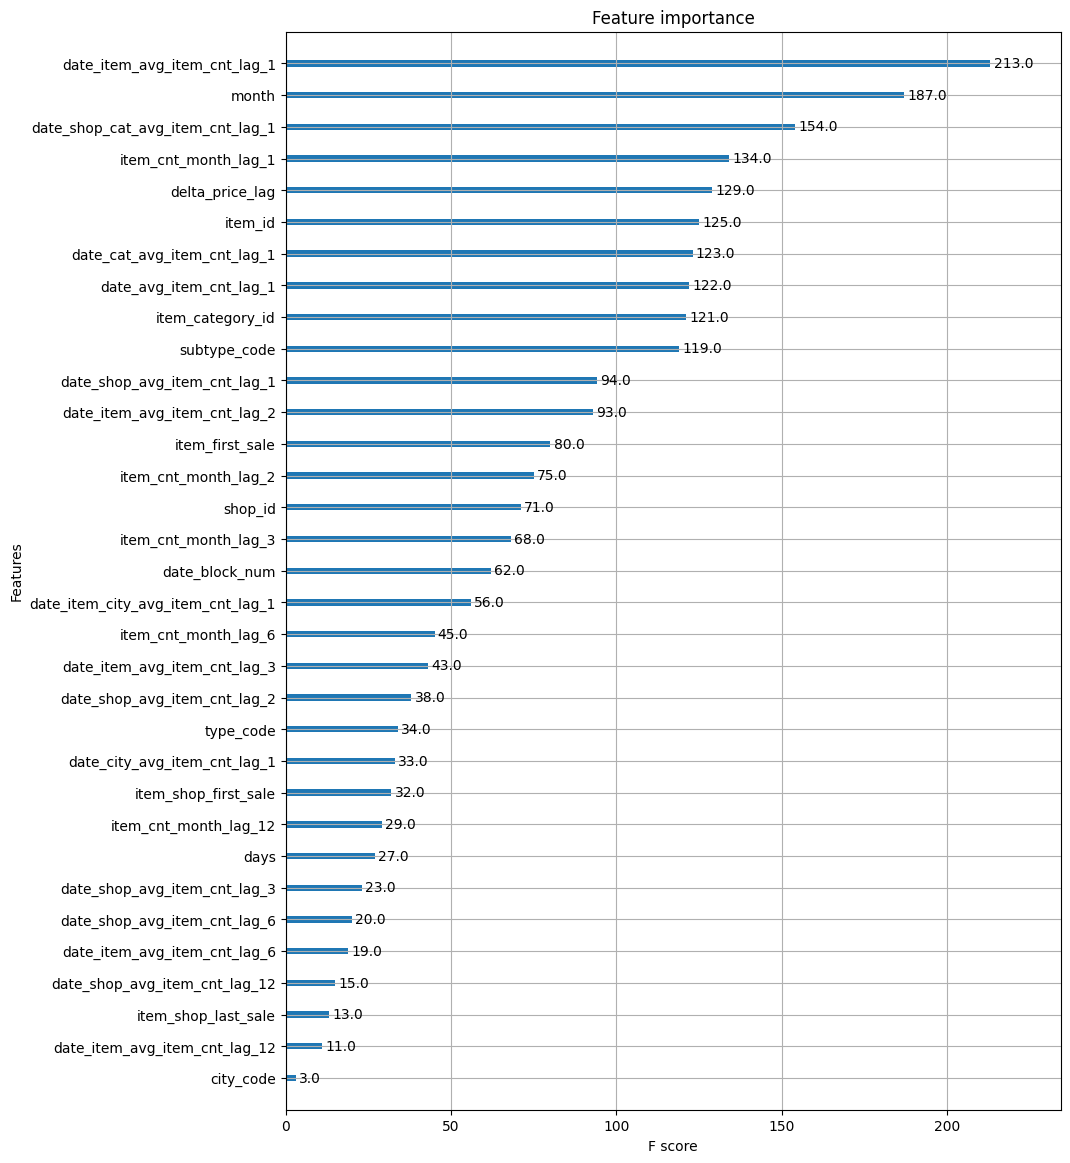

In [67]:
plot_features(model, (10,14))